In [1]:
import os
import tensorflow as tf
import zipfile
import numpy as np
import shutil
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from scipy.ndimage import rotate
from skimage.exposure import adjust_gamma
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# -------------------------------------------------
# 1) Ekstrak dataset (jika belum ada folder 'dataset')
# -------------------------------------------------
dataset_path = 'C:/Users/FIKRI/Documents/Model/dataset.zip'
extract_path = 'C:/Users/FIKRI/Documents/Model'

if not os.path.exists(os.path.join(extract_path, 'dataset')):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Pastikan kita punya 3 folder kelas di:
# [path]/dataset/anorganik
# [path]/dataset/organik
# [path]/dataset/bukansampah

In [3]:
dataset_dir = os.path.join(extract_path, 'dataset')
classes = ['anorganik', 'bukansampah', 'organik']

# Cek jumlah data asli di setiap kelas
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    num_images = len(os.listdir(class_path))
    print(f"Jumlah gambar di kelas {cls}: {num_images}")

Jumlah gambar di kelas anorganik: 889
Jumlah gambar di kelas bukansampah: 3008
Jumlah gambar di kelas organik: 345


In [ ]:
# -------------------------------------------------
# 2) Split data asli menjadi train & val (80:20)
#    tanpa augmentasi apa pun
# -------------------------------------------------
split_dir = os.path.join(extract_path, 'splitted_data')
train_original_dir = os.path.join(split_dir, 'train_original')
val_original_dir   = os.path.join(split_dir, 'val_original')

# Buat folder jika belum ada
os.makedirs(train_original_dir, exist_ok=True)
os.makedirs(val_original_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(train_original_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_original_dir, cls), exist_ok=True)

# Lakukan split data
for cls in classes:
    input_class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(input_class_dir)

    # Split 80:20
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Copy ke folder train_original
    for img_name in train_imgs:
        src = os.path.join(input_class_dir, img_name)
        dst = os.path.join(train_original_dir, cls, img_name)
        shutil.copy(src, dst)

    # Copy ke folder val_original
    for img_name in val_imgs:
        src = os.path.join(input_class_dir, img_name)
        dst = os.path.join(val_original_dir, cls, img_name)
        shutil.copy(src, dst)

print("Split data asli -> train_original & val_original selesai.")

In [ ]:
# -------------------------------------------------
# 3) Augmentasi hanya untuk data train
#    (val dibiarkan apa adanya)
# -------------------------------------------------

# Folder output augmentasi train
aug_train_dir = os.path.join(split_dir, 'train_aug')
os.makedirs(aug_train_dir, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(aug_train_dir, cls), exist_ok=True)

# Fungsi rotasi
def custom_rotation(img_array, rotation_angles):
    augmented_images = []
    for angle in rotation_angles:
        # rotate dari scipy.ndimage
        augmented_img = rotate(img_array, angle, reshape=False, mode='constant', cval=0)
        augmented_img = np.clip(augmented_img, 0, 255).astype('uint8')
        augmented_images.append(augmented_img)
    return augmented_images

# Fungsi mengatur kontras
def adjust_contrast(img_array, gamma):
    # adjust_gamma dari skimage.exposure
    augmented_img = adjust_gamma(img_array, gamma=gamma)
    augmented_img = np.clip(augmented_img, 0, 255).astype('uint8')
    return augmented_img

# Fungsi augmentasi lainnya (ImageDataGenerator)
def apply_other_augmentations(img_array, datagen, num_augmented_images=1):
    # Tambah dimensi batch
    img_array = img_array.reshape((1,) + img_array.shape)
    augmented_images = []
    for _ in range(num_augmented_images):
        augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
        augmented_img = np.clip(augmented_img, 0, 255).astype('uint8')
        augmented_images.append(augmented_img)
    return augmented_images

# Definisikan ImageDataGenerator khusus untuk masing-masing kelas (opsional)
datagen_anorganik = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

datagen_organik = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.2, 1.0),
    zoom_range=[0.8, 0.4],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

datagen_bukansampah = ImageDataGenerator(
    rotation_range=10,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

# Parameter augmentasi
rotation_angles = [-20, 20, -30, 30]
gamma_values = [0.5, 1.2]
target_size = (600, 800)  # Ukuran resize saat augmentasi
num_aug = 2               # Berapa kali augmentasi (ImageDataGenerator) per rotasi

# Loop per kelas untuk augmentasi
for cls in classes:
    input_path = os.path.join(train_original_dir, cls)  # folder train_original
    output_path = os.path.join(aug_train_dir, cls)      # folder train_aug

    images = os.listdir(input_path)

    # Pilih generator sesuai kelas
    if cls == "anorganik":
        datagen = datagen_anorganik
    elif cls == "organik":
        datagen = datagen_organik
    else:
        datagen = datagen_bukansampah

    for img_file in images:
        img_path = os.path.join(input_path, img_file)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)

        # Augmentasi rotasi manual
        rotated_images = custom_rotation(img_array, rotation_angles)

        # Kumpulkan semua augmented
        all_augmented_images = []
        for rotated_img in rotated_images:
            # Augmentasi pakai ImageDataGenerator
            augmented_images = apply_other_augmentations(rotated_img, datagen, num_aug)
            all_augmented_images.extend(augmented_images)

            # Tambahkan variasi kontras
            for gamma in gamma_values:
                contrast_img = adjust_contrast(rotated_img, gamma)
                all_augmented_images.append(contrast_img)

        # Simpan hasil augmentasi
        # Juga simpan original image agar train mencakup gambar aslinya
        # (Jika mau menyimpan aslinya di folder augmented, boleh juga)
        # save_img(os.path.join(output_path, img_file), img_array.astype('uint8'))

        # Untuk menjaga agar data augmented tidak meledak jumlahnya,
        # kita bisa batasi sesuai kebutuhan. Di sini disimpan semua:
        for i, augmented_img in enumerate(all_augmented_images):
            save_path = os.path.join(output_path, f'{cls}_{img_file.split(".")[0]}_aug_{i+1}.jpg')
            save_img(save_path, augmented_img)

print("Augmentasi train selesai.")

In [ ]:
# -------------------------------------------------
# 4) Siapkan folder final train & val
#    (Kita akan gabung: data original train + data augmented)
# -------------------------------------------------
final_train_dir = os.path.join(extract_path, 'train_data')
final_val_dir   = os.path.join(extract_path, 'val_data')

# Bersihkan folder jika sudah ada
if os.path.exists(final_train_dir):
    shutil.rmtree(final_train_dir)
if os.path.exists(final_val_dir):
    shutil.rmtree(final_val_dir)

os.makedirs(final_train_dir, exist_ok=True)
os.makedirs(final_val_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(final_train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(final_val_dir, cls), exist_ok=True)

# Copy data original train ke final_train_dir
for cls in classes:
    src_path = os.path.join(train_original_dir, cls)
    dst_path = os.path.join(final_train_dir, cls)
    for img_file in os.listdir(src_path):
        shutil.copy(os.path.join(src_path, img_file), os.path.join(dst_path, img_file))

# Copy data augmented train ke final_train_dir
for cls in classes:
    src_path = os.path.join(aug_train_dir, cls)
    dst_path = os.path.join(final_train_dir, cls)
    for img_file in os.listdir(src_path):
        shutil.copy(os.path.join(src_path, img_file), os.path.join(dst_path, img_file))

# Copy data val_original ke final_val_dir
for cls in classes:
    src_path = os.path.join(val_original_dir, cls)
    dst_path = os.path.join(final_val_dir, cls)
    for img_file in os.listdir(src_path):
        shutil.copy(os.path.join(src_path, img_file), os.path.join(dst_path, img_file))

print("Folder train_data dan val_data siap (gabungan original + augmented).")

In [4]:
final_train_dir = os.path.join(extract_path, 'train_data')
final_val_dir   = os.path.join(extract_path, 'val_data')

In [5]:
# -------------------------------------------------
# 5) Buat ImageDataGenerator untuk training & validasi
# -------------------------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    final_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    final_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 29300 images belonging to 3 classes.
Found 843 images belonging to 3 classes.


In [6]:
# -------------------------------------------------
# 6) Definisikan Model (MobileNetV2 + Fine-Tuning)
# -------------------------------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Fine-tuning: freeze layer kecuali 20 terakhir
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    #Dropout(0.4),
    Dense(128, activation='relu'),
    #Dropout(0.4),
    Dense(3, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("Class Indices (Train):", train_generator.class_indices)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,619,203
Trainable params: 1,567,299
Non-

In [7]:
# -------------------------------------------------
# 7) Training
# -------------------------------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model_test.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10
916/916 [==============================] - 113s 117ms/step - loss: 0.1232 - accuracy: 0.9707 - val_loss: 0.0257 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 2/10
916/916 [==============================] - 91s 99ms/step - loss: 0.0136 - accuracy: 0.9967 - val_loss: 0.0048 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 3/10
916/916 [==============================] - 98s 106ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0027 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 4/10
916/916 [==============================] - 103s 113ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 0.9988 - lr: 1.0000e-05
Epoch 5/10
916/916 [==============================] - 95s 104ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9988 - lr: 1.0000e-05
Epoch 6/10
916/916 [==============================] - 92s 101ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 7/10
916/916 [=======

27/27 [==============================] - 4s 161ms/step - loss: 0.0018 - accuracy: 1.0000
Akurasi pada data validasi: 1.00


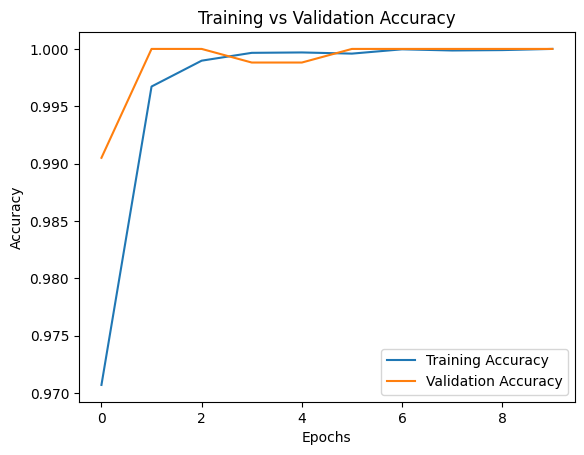

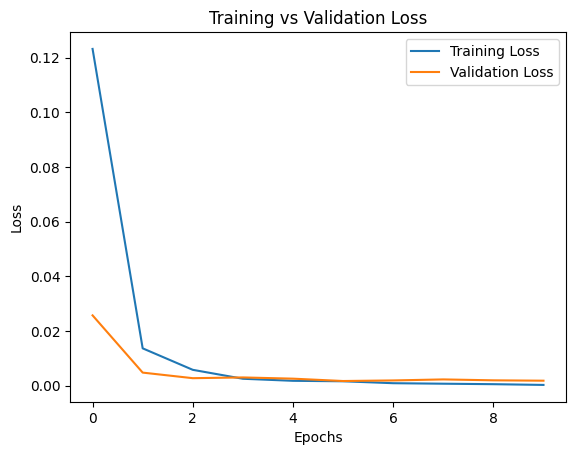

27/27 [==============================] - 5s 154ms/step


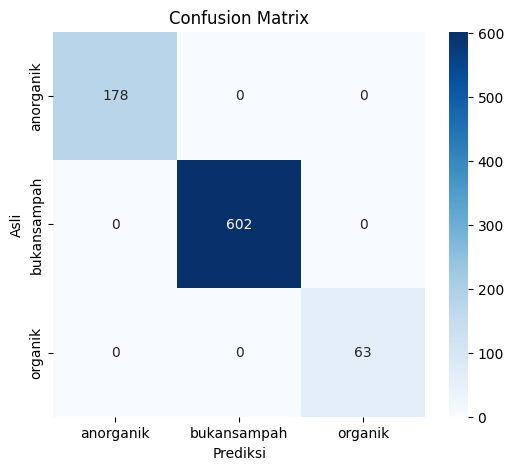


Classification Report:
              precision    recall  f1-score   support

   anorganik       1.00      1.00      1.00       178
 bukansampah       1.00      1.00      1.00       602
     organik       1.00      1.00      1.00        63

    accuracy                           1.00       843
   macro avg       1.00      1.00      1.00       843
weighted avg       1.00      1.00      1.00       843



In [8]:
# -------------------------------------------------
# 8) Evaluasi Model & Confusion Matrix
# -------------------------------------------------
loss, accuracy = model.evaluate(val_generator)
print(f"Akurasi pada data validasi: {accuracy:.2f}")

# Plot Akurasi
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Confusion Matrix
Y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(val_generator.class_indices.keys()),
            yticklabels=list(val_generator.class_indices.keys()))
plt.xlabel("Prediksi")
plt.ylabel("Asli")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

In [ ]:
# -------------------------------------------------
# 9) Konversi model ke .onnx
# -------------------------------------------------
import tf2onnx
onnx_model_path = "mobilenetv2.onnx"
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Model berhasil dikonversi ke ONNX: {onnx_model_path}")